In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdDepictor
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 700,700
from tabs import DihedralInfoFromTorsionLib
from tabs import custom
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

Reading in the macrocycle

In [7]:
template = Chem.MolFromMolFile("../Data/Tests/ligand.sdf",removeHs=False)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

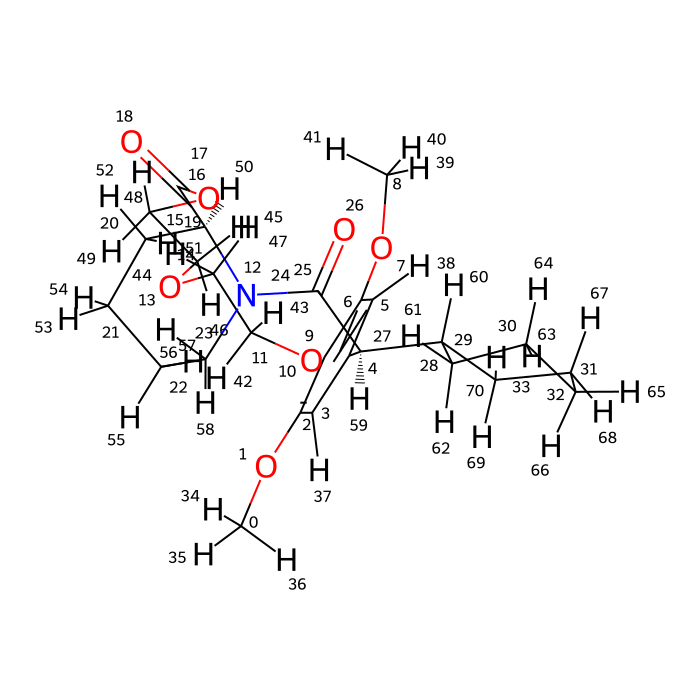

In [8]:
rdDepictor.SetPreferCoordGen(True)
template

Getting the experimental torsion information matched through the ET terms in the ETKDG and also add additional dihedrals of interest

In [9]:
etInfo = DihedralInfoFromTorsionLib(template)
# get indices where TorsionType is MACROCYCLE
macrocycle_indices = [i for i, torsion in enumerate(etInfo.torsionTypes) if torsion == 3]
mcDihedrals = etInfo.indices[15:]
mcDihedrals.append([2,9,10,11])
mcDihedrals.append([3,4,27,25])
mcDihedrals.append([24,19,17,16])
mcDihedrals

[[27, 25, 24, 19],
 [18, 17, 16, 15],
 [17, 16, 15, 14],
 [11, 12, 13, 14],
 [15, 14, 13, 12],
 [12, 11, 10, 9],
 [10, 11, 12, 13],
 [13, 14, 15, 16],
 [4, 27, 25, 26],
 [2, 9, 10, 11],
 [3, 4, 27, 25],
 [24, 19, 17, 16]]

Correlation Analysis

In [10]:
molTop = Chem.MolFromPDBFile("/home/braunje/Macrocycles/Enrico/reference.pdb",removeHs=False)

In [11]:
mol2 = AllChem.AssignBondOrdersFromTemplate(template, molTop)

[15:41:56] WARNING: More than one matching pattern found - picking one



In [12]:
traj = md.load("/home/braunje/Macrocycles/Enrico/ensemble-0.dcd",\
        top="/home/braunje/Macrocycles/Enrico/reference.pdb")

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [13]:
molTop = Chem.AddHs(Chem.MolFromPDBFile("/home/braunje/Macrocycles/Enrico/reference.pdb", removeHs=False),addCoords=True)
Chem.MolToMolFile(molTop, "/home/braunje/Macrocycles/Enrico/reference2.sdf")

In [15]:
def GetTabsPopulationMatrix(uniqueTabs, counts):
    statesA = set()
    statesB = set()
    for tabs in uniqueTabs:
        s = str(tabs)
        statesA.add(int(s[0]))
        statesB.add(int(s[1]))
    # get the maximum in statesA and statesB
    maxA = max(statesA)
    maxB = max(statesB)
    # create a matrix with the size of maxA x maxB
    matrix = np.zeros((maxA, maxB), dtype=int)
    for tabs, count in zip(uniqueTabs, counts):
        s = str(tabs)
        a = int(s[0]) - 1  # convert to zero-based index
        b = int(s[1]) - 1  # convert to zero-based index
        matrix[a, b] += count
    return matrix

In [16]:
def CheckForCorrelationCandidates(candidates, traj, threshold=0.05):
    relevant = []
    # not relevant for correlation analysis if there is only one state
    for dihedral in candidates:
        customProfile = custom.GetTorsionProfilesFromMDTraj(traj, [dihedral])
        info = custom.CustomDihedralInfo(mol2, [dihedral], customProfile, showFits=False)
        tabsPopulationTraj = info.GetTABS(confTorsions=customProfile)
        unique, counts = np.unique(tabsPopulationTraj, return_counts=True)
        percentages = counts / len(tabsPopulationTraj) * 100
        if len(unique) > 1:
            # check if the percentage of the most populated state is above the threshold
            if min(percentages) > threshold:
                relevant.append(dihedral)
            else:
                print(f"Dihedral {dihedral} not relevant: {percentages}")
        else:
            print(f"Dihedral {dihedral} not relevant: {percentages}")
    return relevant

In [15]:
todump = {}
for dihedral in mcDihedrals:
    customProfile = custom.GetTorsionProfilesFromMDTraj(traj, [dihedral])
    todump[tuple(dihedral)] = customProfile

In [18]:
with open("../Data/Tests/macrocycleDihedralProfiles.pkl", "wb") as f:
    import pickle
    pickle.dump(todump, f)

In [17]:
todump[(27,25,24,19)]

array([[3.1199343],
       [2.973681 ],
       [2.6415582],
       ...,
       [2.7220569],
       [2.7682714],
       [2.9319055]], shape=(20001, 1), dtype=float32)

In [17]:
idxs = CheckForCorrelationCandidates(mcDihedrals, traj, threshold=1)

/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


Dihedral [27, 25, 24, 19] not relevant: [6.99965002e-02 9.99300035e+01]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


Dihedral [18, 17, 16, 15] not relevant: [99.08504575  0.91495425]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)
/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)
/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)
/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)
/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)
/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/

Dihedral [13, 14, 15, 16] not relevant: [47.49762512  0.50497475 51.99740013]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


Dihedral [4, 27, 25, 26] not relevant: [9.99350032e+01 6.49967502e-02]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)
/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


Dihedral [3, 4, 27, 25] not relevant: [100.]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


In [18]:
len(idxs)

7

In [19]:
# get all pairs of dihedrals
pairs = []
for i in range(len(idxs)):
    for j in range(i+1, len(idxs)):
        pairs.append((idxs[i], idxs[j]))

In [20]:
len(pairs)

21

In [21]:
pValues = []
for pairIndex in range(len(pairs)):    
    customProfiles = custom.GetTorsionProfilesFromMDTraj(traj, pairs[pairIndex])
    #customProfiles = custom.GetTorsionProfilesFromMDTraj(traj, [mcDihedrals[dihedralIndex]])
    #binsize = np.pi*2/36
    #yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles,binsize)
    info2 = custom.CustomDihedralInfo(mol2, pairs[pairIndex], customProfiles, showFits=False)
    #info2 = custom.CustomDihedralInfo(mol2, [mcDihedrals[dihedralIndex]], customProfiles, showFits=True)
    print(pairs[pairIndex])
    tabsPopulationTraj = info2.GetTABS(confTorsions=customProfiles)
    # count the number for each unique value
    unique, counts = np.unique(tabsPopulationTraj, return_counts=True)
    print("Unique values:", unique)
    print("Counts:", counts)
    # percentage of each unique value
    percentages = counts / len(tabsPopulationTraj) * 100
    print("Counts reshaped:", counts)
    print("Percentages:", percentages)
    m = GetTabsPopulationMatrix(unique, counts)
    res = chi2_contingency(m)
    pValues.append((pairs[pairIndex][0], pairs[pairIndex][1], res.statistic, res.pvalue))

/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([17, 16, 15, 14], [11, 12, 13, 14])
Unique values: [11 12 13 21 22 23 31 32 33]
Counts: [   53  3188   133  1342 11843  2794    10   527   111]
Counts reshaped: [   53  3188   133  1342 11843  2794    10   527   111]
Percentages: [2.64986751e-01 1.59392030e+01 6.64966752e-01 6.70966452e+00
 5.92120394e+01 1.39693015e+01 4.99975001e-02 2.63486826e+00
 5.54972251e-01]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([17, 16, 15, 14], [15, 14, 13, 12])
Unique values: [11 12 13 21 22 23 31 32 33]
Counts: [   88  2795   491   365  1184 14430   113     5   530]
Counts reshaped: [   88  2795   491   365  1184 14430   113     5   530]
Percentages: [4.39978001e-01 1.39743013e+01 2.45487726e+00 1.82490875e+00
 5.91970401e+00 7.21463927e+01 5.64971751e-01 2.49987501e-02
 2.64986751e+00]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([17, 16, 15, 14], [12, 11, 10, 9])
Unique values: [11 12 21 22 31 32]
Counts: [  354  3020  5203 10776   225   423]
Counts reshaped: [  354  3020  5203 10776   225   423]
Percentages: [ 1.7699115  15.09924504 26.01369932 53.87730613  1.12494375  2.11489426]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([17, 16, 15, 14], [10, 11, 12, 13])
Unique values: [11 12 21 22 31 32]
Counts: [  569  2805  5624 10355   226   422]
Counts reshaped: [  569  2805  5624 10355   226   422]
Percentages: [ 2.84485776 14.02429879 28.11859407 51.77241138  1.1299435   2.10989451]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([17, 16, 15, 14], [2, 9, 10, 11])
Unique values: [11 12 21 22 31 32]
Counts: [ 3049   325 11185  4794   445   203]
Counts reshaped: [ 3049   325 11185  4794   445   203]
Percentages: [15.24423779  1.62491875 55.92220389 23.96880156  2.22488876  1.01494925]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([17, 16, 15, 14], [24, 19, 17, 16])
Unique values: [11 12 21 22 31 32]
Counts: [ 3362    12 12658  3321   125   523]
Counts reshaped: [ 3362    12 12658  3321   125   523]
Percentages: [1.68091595e+01 5.99970001e-02 6.32868357e+01 1.66041698e+01
 6.24968752e-01 2.61486926e+00]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([11, 12, 13, 14], [15, 14, 13, 12])
Unique values: [11 12 13 21 22 23 31 32 33]
Counts: [   10     5  1390   545  3780 11233    11   199  2828]
Counts reshaped: [   10     5  1390   545  3780 11233    11   199  2828]
Percentages: [4.99975001e-02 2.49987501e-02 6.94965252e+00 2.72486376e+00
 1.88990550e+01 5.61621919e+01 5.49972501e-02 9.94950252e-01
 1.41392930e+01]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([11, 12, 13, 14], [12, 11, 10, 9])
Unique values: [11 12 21 22 31 32]
Counts: [    2  1403  2756 12802  3024    14]
Counts reshaped: [    2  1403  2756 12802  3024    14]
Percentages: [9.99950002e-03 7.01464927e+00 1.37793110e+01 6.40067997e+01
 1.51192440e+01 6.99965002e-02]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([11, 12, 13, 14], [10, 11, 12, 13])
Unique values: [11 12 21 22 31 32]
Counts: [    2  1403  3394 12164  3023    15]
Counts reshaped: [    2  1403  3394 12164  3023    15]
Percentages: [9.99950002e-03 7.01464927e+00 1.69691515e+01 6.08169592e+01
 1.51142443e+01 7.49962502e-02]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([11, 12, 13, 14], [2, 9, 10, 11])
Unique values: [11 12 21 22 31 32]
Counts: [ 1402     3 13044  2514   233  2805]
Counts reshaped: [ 1402     3 13044  2514   233  2805]
Percentages: [7.00964952e+00 1.49992500e-02 6.52167392e+01 1.25693715e+01
 1.16494175e+00 1.40242988e+01]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([11, 12, 13, 14], [24, 19, 17, 16])
Unique values: [11 12 21 22 31 32]
Counts: [ 1274   131 12325  3233  2546   492]
Counts reshaped: [ 1274   131 12325  3233  2546   492]
Percentages: [ 6.36968152  0.65496725 61.6219189  16.16419179 12.72936353  2.45987701]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([15, 14, 13, 12], [12, 11, 10, 9])
Unique values: [11 12 21 22 31 32]
Counts: [  177   389   214  3770  5391 10060]
Counts reshaped: [  177   389   214  3770  5391 10060]
Percentages: [ 0.88495575  1.94490275  1.0699465  18.84905755 26.95365232 50.29748513]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([15, 14, 13, 12], [10, 11, 12, 13])
Unique values: [11 12 21 22 31 32]
Counts: [ 545   21  208 3776 5666 9785]
Counts reshaped: [ 545   21  208 3776 5666 9785]
Percentages: [ 2.72486376  0.10499475  1.039948   18.87905605 28.32858357 48.92255387]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([15, 14, 13, 12], [2, 9, 10, 11])
Unique values: [11 12 21 22 31 32]
Counts: [  407   159  3794   190 10478  4973]
Counts reshaped: [  407   159  3794   190 10478  4973]
Percentages: [ 2.03489826  0.79496025 18.96905155  0.9499525  52.38738063 24.86375681]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([15, 14, 13, 12], [24, 19, 17, 16])
Unique values: [11 12 21 22 31 32]
Counts: [  277   289  2813  1171 13055  2396]
Counts reshaped: [  277   289  2813  1171 13055  2396]
Percentages: [ 1.38493075  1.44492775 14.06429679  5.85470726 65.27173641 11.97940103]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([12, 11, 10, 9], [10, 11, 12, 13])
Unique values: [11 12 21 22]
Counts: [ 5766    16   653 13566]
Counts reshaped: [ 5766    16   653 13566]
Percentages: [28.82855857  0.079996    3.26483676 67.82660867]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([12, 11, 10, 9], [2, 9, 10, 11])
Unique values: [11 12 21 22]
Counts: [  468  5314 14211     8]
Counts reshaped: [  468  5314 14211     8]
Percentages: [2.33988301e+00 2.65686716e+01 7.10514474e+01 3.99980001e-02]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([12, 11, 10, 9], [24, 19, 17, 16])
Unique values: [11 12 21 22]
Counts: [ 4647  1135 11498  2721]
Counts reshaped: [ 4647  1135 11498  2721]
Percentages: [23.23383831  5.67471626 57.48712564 13.60431978]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([10, 11, 12, 13], [2, 9, 10, 11])
Unique values: [11 12 21 22]
Counts: [ 1121  5298 13558    24]
Counts reshaped: [ 1121  5298 13558    24]
Percentages: [ 5.60471976 26.48867557 67.78661067  0.119994  ]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


([10, 11, 12, 13], [24, 19, 17, 16])
Unique values: [11 12 21 22]
Counts: [ 4875  1544 11270  2312]
Counts reshaped: [ 4875  1544 11270  2312]
Percentages: [24.37378131  7.71961402 56.34718264 11.55942203]
([2, 9, 10, 11], [24, 19, 17, 16])
Unique values: [11 12 21 22]
Counts: [11892  2787  4253  1069]
Counts reshaped: [11892  2787  4253  1069]
Percentages: [59.45702715 13.93430328 21.2639368   5.34473276]


/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


In [22]:
pValues

[([17, 16, 15, 14],
  [11, 12, 13, 14],
  np.float64(701.2903522460135),
  np.float64(1.8316376747937274e-150)),
 ([17, 16, 15, 14],
  [15, 14, 13, 12],
  np.float64(10657.775378410894),
  np.float64(0.0)),
 ([17, 16, 15, 14],
  [12, 11, 10, 9],
  np.float64(671.2315398955301),
  np.float64(1.7535698586704156e-146)),
 ([17, 16, 15, 14],
  [10, 11, 12, 13],
  np.float64(431.9517931134002),
  np.float64(1.5953644169865807e-94)),
 ([17, 16, 15, 14],
  [2, 9, 10, 11],
  np.float64(599.5164978518304),
  np.float64(6.556115356609431e-131)),
 ([17, 16, 15, 14],
  [24, 19, 17, 16],
  np.float64(2370.976586269184),
  np.float64(0.0)),
 ([11, 12, 13, 14],
  [15, 14, 13, 12],
  np.float64(1040.2372108642833),
  np.float64(6.796671886735247e-224)),
 ([11, 12, 13, 14],
  [12, 11, 10, 9],
  np.float64(8888.799601324155),
  np.float64(0.0)),
 ([11, 12, 13, 14],
  [10, 11, 12, 13],
  np.float64(7747.287533936733),
  np.float64(0.0)),
 ([11, 12, 13, 14],
  [2, 9, 10, 11],
  np.float64(8090.744194329309

In [23]:
import pandas as pd

In [24]:
res = pd.DataFrame(pValues, columns=["Dihedral A", "Dihedral B", "stats", "p-value"])

In [25]:
res

,Dihedral A,Dihedral B,stats,p-value
0,"[17, 16, 15, 14]","[11, 12, 13, 14]",701.290352,1.831638e-150
1,"[17, 16, 15, 14]","[15, 14, 13, 12]",10657.775378,0.000000e+00
2,"[17, 16, 15, 14]","[12, 11, 10, 9]",671.231540,1.753570e-146
3,"[17, 16, 15, 14]","[10, 11, 12, 13]",431.951793,1.595364e-94
4,"[17, 16, 15, 14]","[2, 9, 10, 11]",599.516498,6.556115e-131
5,"[17, 16, 15, 14]","[24, 19, 17, 16]",2370.976586,0.000000e+00
6,"[11, 12, 13, 14]","[15, 14, 13, 12]",1040.237211,6.796672e-224
7,"[11, 12, 13, 14]","[12, 11, 10, 9]",8888.799601,0.000000e+00
8,"[11, 12, 13, 14]","[10, 11, 12, 13]",7747.287534,0.000000e+00
9,"[11, 12, 13, 14]","[2, 9, 10, 11]",8090.744194,0.000000e+00


In [26]:
res.sort_values(by="p-value", ascending=True, inplace=False)
target = [24, 19, 17, 16]
sub = res[res["Dihedral B"].apply(lambda x: x == target)]

In [27]:
sub.sort_values(by="stats", ascending=True, inplace=False)

,Dihedral A,Dihedral B,stats,p-value
17,"[12, 11, 10, 9]","[24, 19, 17, 16]",0.612005,4.340339e-01
20,"[2, 9, 10, 11]","[24, 19, 17, 16]",2.967339,8.496151e-02
10,"[11, 12, 13, 14]","[24, 19, 17, 16]",130.576662,4.422197e-29
19,"[10, 11, 12, 13]","[24, 19, 17, 16]",138.016584,7.227070e-32
14,"[15, 14, 13, 12]","[24, 19, 17, 16]",770.460423,4.973303e-168
5,"[17, 16, 15, 14]","[24, 19, 17, 16]",2370.976586,0.000000e+00


In [50]:
4.422197e-29

4.422197e-29

previously

In [28]:
indicesOfInterest = [[24,19,17,16],
                     [17,16,15,14],
                     [10,11,12,13]]

In [29]:
plt.rcParams["font.size"] = 14

In [30]:
customProfiles = custom.GetTorsionProfilesFromMDTraj(traj, indicesOfInterest)

In [31]:
binsize = np.pi*2/36
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles,binsize)

/localhome/braunje/.conda/envs/tabs/lib/python3.13/site-packages/tabs/custom.py:15: UserWarning: WARNING: Molecule has chiral centers with undefined stereo
  clsInst = DihedralsInfo(mol)


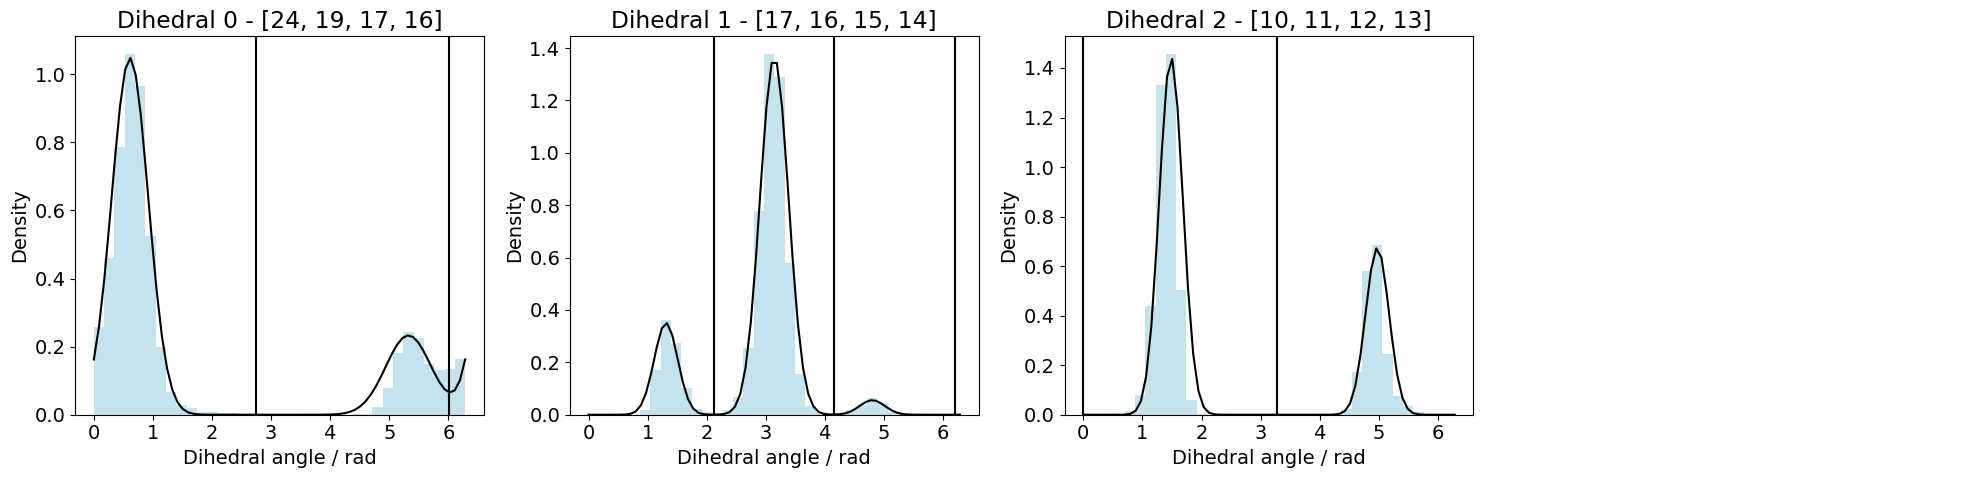

In [32]:
info2 = custom.CustomDihedralInfo(mol2, indicesOfInterest, customProfiles, showFits=True)

Text(0, 0.5, 'Density')

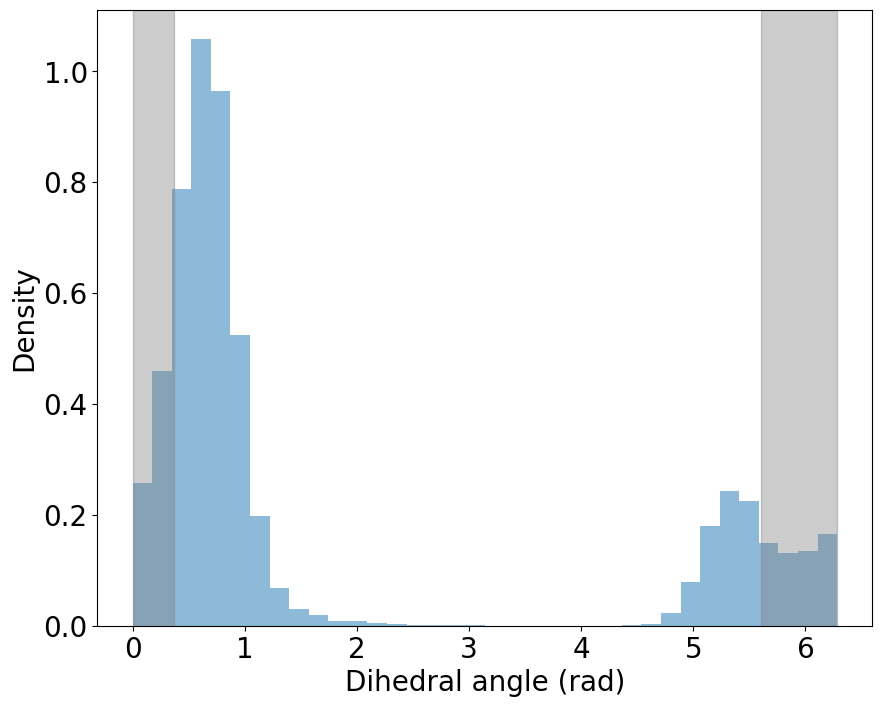

In [33]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(xHist, yHists[0], width=binsize, alpha=0.5)
#ax.vlines(np.deg2rad(21),0,1.1, color='red', linestyle='--')
#ax.vlines(np.deg2rad(321),0,1.1, color='red', linestyle='--')
ax.axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax.axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax.set_xlabel("Dihedral angle (rad)")
ax.set_ylabel("Density")

In [34]:
fig.savefig("/tmp/dihedralHistogramTorsionband.pdf",dpi=800)

In [35]:
tabsPopulationTraj = info2.GetTABS(confTorsions=customProfiles)

In [36]:
# count the number for each unique value
unique, counts = np.unique(tabsPopulationTraj, return_counts=True)

In [37]:
print(unique, counts)

[111 112 121 122 131 132 211 212 221 222 231 232] [ 567 2795 4199 8459  109   16    2   10 1425 1896  117  406]


In [38]:
GetTabsPopulationMatrix(unique, counts)

array([[ 3362, 12658,   125],
       [   12,  3321,   523]])

In [39]:
tabsPopulationTraj[0]

122

In [40]:
#get all indices of the TABS that have 1 as the first value
indices1 = []
indices2 = []
for i in range(len(tabsPopulationTraj)):
    if str(tabsPopulationTraj[i]).startswith("1"):
        indices1.append(i)
    if str(tabsPopulationTraj[i]).startswith("2"):
        indices2.append(i)

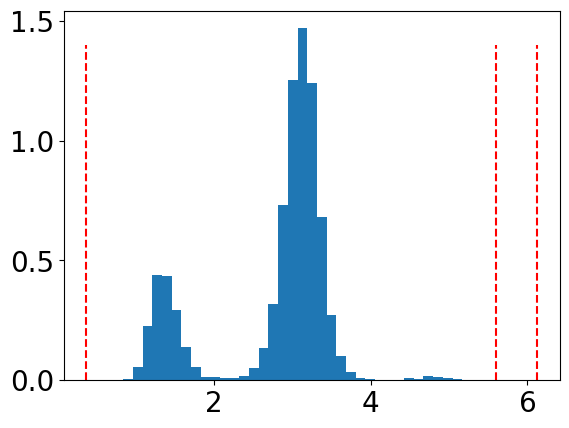

In [41]:
import matplotlib.pyplot as plt
plt.hist(customProfiles[indices1,1], bins=36, density=True)
plt.vlines(np.deg2rad(360-9), 0, 1.4, color='red', linestyle='--')
plt.vlines(np.deg2rad(360-9-30), 0, 1.4, color='red', linestyle='--')
plt.vlines(np.deg2rad((360-9+30)%360), 0, 1.4, color='red', linestyle='--')

In [42]:
binsize = np.pi*2/36

In [43]:
customProfiles.shape

(20001, 3)

Text(0.5, 0, 'Dihedral angle (rad)')

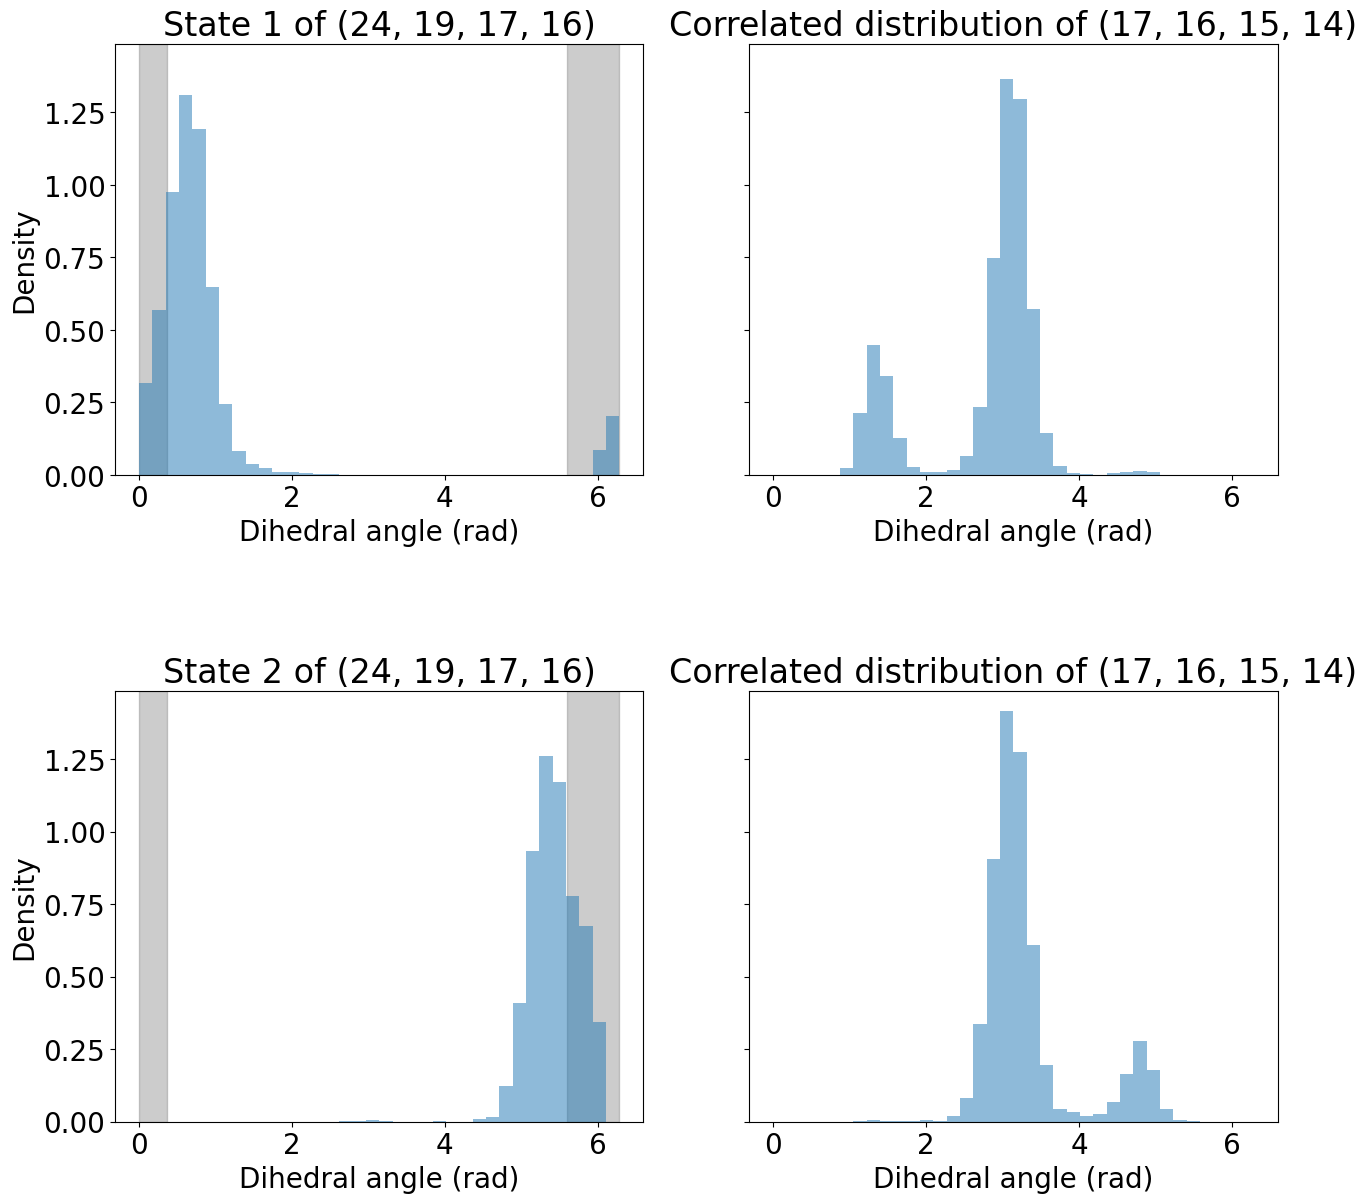

In [45]:
plt.rcParams['font.size'] = 20
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles[indices1,:],binsize)
yHists2, yHistsCount2, xHist2 = custom.ComputeTorsionHistograms(customProfiles[indices2,:],binsize)
fig, ax = plt.subplots(2, 2, figsize=(15, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
ax[0][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[0][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[0][0].set_title("State 1 of (24, 19, 17, 16)")
ax[0][0].bar(xHist, yHists[0], width=binsize, alpha=0.5)
ax[0][0].set_xlabel("Dihedral angle (rad)")
ax[0][0].set_ylabel("Density")
ax[0][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[0][1].bar(xHist, yHists[1], width=binsize, alpha=0.5)
ax[0][1].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_title("State 2 of (24, 19, 17, 16)")
ax[1][0].bar(xHist2, yHists2[0], width=binsize, alpha=0.5)
ax[1][0].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_ylabel("Density")
ax[1][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[1][1].bar(xHist2, yHists2[1], width=binsize, alpha=0.5)
ax[1][1].set_xlabel("Dihedral angle (rad)")

In [46]:
fig.savefig("/tmp/dihedralHistogramsTabsCorrelations.pdf",dpi=800)